# Model Training - Classic Cross-Validation

Various combinations of model architectures, features, and training approaches were tested:

## Model Architectures
1. **Baseline Model (avg)**: Predict the average `'K%'` across a pitcher's available data.
2. **Baseline Model (last)**: Predict the last observed `'K%'` from the pitcher's available data.
3. **Baseline Model (xK%)**: Predict `'K%'` using the formula: `xK% = -0.61 + (L/Str * 1.1538) + (S/Str * 1.4696) + (F/Str * 0.9417)` (see [The Definitive Pitcher Expected K% Formula](https://fantasy.fangraphs.com/the-definitive-pitcher-expected-k-formula/)).
4. [**Linear Regression Model**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
5. [**Random Forest Model**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
6. [**XGBoost Model**](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)

## Features
1. **All 67 Features**:
    - 31 categorical one-hot encoded features for teams (30 MLB teams plus `'---'` for multi-team).
    - 36 numeric features.
2. **7 Features Selected from Lasso Model** (see [03-feature-engineering.ipynb](./03-feature-engineering.ipynb)):
    - `'numeric__Pit/PA'`
    - `'numeric__Str%'`
    - `'numeric__F/Str'`
    - `'numeric__I/Str'`
    - `'numeric__Con'`
    - `'numeric__30%'`
    - `'numeric__L/SO'`

## Training Approach
Two training schemas will be utilized for model training, with **MSE** (mean squared error) used to evaluate model performance:
1. **Classical Cross-Validation**: The data will be split into K-folds, with the goal of predicting `'K%'`.
2. **Time-Series Cross-Validation**: Folds will be based on the season, using earlier years (e.g., `2021`) to predict subsequent years (e.g., `2022`), and so on (e.g., `2021-2022` to predict `2023`).

**THIS NOTEBOOK USES THE CLASSICAL CROSS-VALIDATION APPROACH**
- For more details, refer to [02-data-partitioning.ipynb](./02-data-partitioning.ipynb).
```mermaid
graph TD
    A["Player Pool"]
    A --> B["Training Pool"]
    
    subgraph TrainingFlow [" "]
        direction LR
        D["2021 --- 2022 --- 2023 "]
        F["X 2024"]:::red
    end
    B -- Training Flow --> D

    
    subgraph CVClassic ["Classic CV: All years used to predict K%"]
        FoldTitle1["Fold1"]:::noBorder
        FoldTitle2["Fold2"]:::noBorder
        FoldTitle3["Fold3"]:::noBorder
    
        Split1["Split1"]:::noBorder
        Fold1["Fold1"]:::blue
        Fold2["Fold2"]:::green
        Fold3["Fold3"]:::green
        
        Split2["Split2"]:::noBorder
        Fold4["Fold1"]:::green
        Fold5["Fold2"]:::blue
        Fold6["Fold3"]:::green
        
        Split3["Split3"]:::noBorder
        Fold7["Fold1"]:::green
        Fold8["Fold2"]:::green
        Fold9["Fold3"]:::blue
        
        FoldTitle1 ~~~ Fold1
        FoldTitle2 ~~~ Fold2
        FoldTitle3 ~~~ Fold3
        
        Split1 ~~~ Split2
        Split2 ~~~ Split3

        Fold1 ~~~ Fold4
        Fold2 ~~~ Fold5
        Fold3 ~~~ Fold6

        Fold4 ~~~ Fold7
        Fold5 ~~~ Fold8
        Fold6 ~~~ Fold9
    end

    TrainingFlow --> CVClassic

    classDef red fill:#FFCCCC,stroke:#FF0000,stroke-width:2px;
    classDef green fill:#CCFFCC,stroke:#00FF00,stroke-width:2px;
    classDef blue fill:#CCCCFF,stroke:#0000FF,stroke-width:2px;
    classDef noBorder fill:none,stroke:none,color:#000000;
    classDef transparent fill:#FFFFFF,stroke:#FFFFFF,stroke-width:2px,opacity:0;
```

Inspired by scikit-learn:
- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/1.5/modules/cross_validation.html#time-series-split

--- 
## Development Workflow

All functions and pipelines demonstrated in this notebook are defined in the `bullpen.data_utils` and `bullpen.model_utils` modules for clarity, reusability, and unit testing. While this notebook retains the initial development and intent of these functions, their inclusion here is primarily for transparency and ease of reference.  

For production usage, refer to the source code in the `bullpen.data_utils` and `bullpen.model_utils` modules.

In [1]:
import joblib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats
import xgboost as xgb
from sklearn import set_config
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

set_config(display="text")

from bullpen import data_utils, model_utils

In [2]:
train = pd.read_csv(data_utils.DATA_DIR.joinpath("train.csv"))
train

PlayerId Team  Season  MLBAMID           Name  Age  TBF        K%   Rk  \
0       18655  ATL    2021   621345    A.J. Minter   27  221  0.257919  696   
1       18655  ATL    2022   621345    A.J. Minter   28  271  0.346863  649   
2       18655  ATL    2023   621345    A.J. Minter   29  260  0.315385  647   
3       19343  OAK    2022   640462       A.J. Puk   27  281  0.270463  773   
4       19343  MIA    2023   640462       A.J. Puk   28  242  0.322314  755   
..        ...  ...     ...      ...            ...  ...  ...       ...  ...   
983      1943  HOU    2021   425844   Zack Greinke   37  697  0.172166  417   
984      1943  KCR    2022   425844   Zack Greinke   38  585  0.124786  396   
985      1943  KCR    2023   425844   Zack Greinke   39  593  0.163575  353   
986     25918  STL    2022   668868  Zack Thompson   24  136  0.198529  967   
987     25918  STL    2023   668868  Zack Thompson   25  287  0.250871  942   

        IP  ...  02s  02h  L/SO  S/SO  L/SO%  3pK  4pW  PAu  Pitu  Stru  
0     52.1  ...   44    7    11    46  0.193   11    4    0     0     0  
1     70.0  ...   50    2    23    71  0.245   12    0    0     0     0  
2     64.2  ...   40    4    13    69  0.159    8    1    0     0     0  
3     66.1  ...   48    6    22    54  0.289   15    4    0     0     0  
4     56.2  ...   42    6    22    56  0.282   16    0    0     0     0  
..     ...  ...  ...  ...   ...   ...    ...  ...  ...  ...   ...   ...  
983  171.0  ...   51    4    34    85  0.283   13    6    0     0     0  
984  137.0  ...   39    3    22    51  0.301    7    2    0     0     0  
985  142.1  ...   53    6    25    70  0.263   11    2    0     0     0  
986   34.2  ...   40    3    10    17  0.370    3    2    0     0     0  
987   66.1  ...   43    2    23    48  0.324   12    4    0     0     0  

[988 rows x 39 columns]

In [3]:
target = "K%"
drop_cols = ["Name", target]
lasso_features = [
    "Pit/PA",
    "Str%",
    "F/Str",
    "I/Str",
    "Con",
    "30%",
    "L/SO",
]

X_df = train[[c for c in train.columns if c not in drop_cols]]
X_df_lasso = train[lasso_features]

y_df = train[target]

In [4]:
X_df.head()

PlayerId Team  Season  MLBAMID  Age  TBF   Rk    IP   PA   Pit  ...  02s  \
0     18655  ATL    2021   621345   27  221  696  52.1  221   876  ...   44   
1     18655  ATL    2022   621345   28  271  649  70.0  272  1111  ...   50   
2     18655  ATL    2023   621345   29  260  647  64.2  260  1062  ...   40   
3     19343  OAK    2022   640462   27  281  773  66.1  281  1072  ...   48   
4     19343  MIA    2023   640462   28  242  755  56.2  242   950  ...   42   

   02h  L/SO  S/SO  L/SO%  3pK  4pW  PAu  Pitu  Stru  
0    7    11    46  0.193   11    4    0     0     0  
1    2    23    71  0.245   12    0    0     0     0  
2    4    13    69  0.159    8    1    0     0     0  
3    6    22    54  0.289   15    4    0     0     0  
4    6    22    56  0.282   16    0    0     0     0  

[5 rows x 37 columns]

In [5]:
X_df_lasso.head()

Pit/PA   Str%  F/Str  I/Str    Con    30%  L/SO
0    3.96  0.660  0.268  0.247  0.687  0.045    11
1    4.08  0.669  0.301  0.214  0.668  0.029    23
2    4.08  0.658  0.300  0.225  0.685  0.023    13
3    3.81  0.655  0.269  0.245  0.708  0.046    22
4    3.93  0.684  0.243  0.229  0.670  0.025    22

In [6]:
y_df.head()

0    0.257919
1    0.346863
2    0.315385
3    0.270463
4    0.322314
Name: K%, dtype: float64

In [7]:
processor = model_utils.make_processing_pipeline(
    categorical_features=["Team"],
    numeric_features=[f for f in X_df.columns if f not in ("Team")],
)

processor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Team']),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['PlayerId', 'Season', 'MLBAMID', 'Age', 'TBF',
                                  'Rk', 'IP', 'PA', 'Pit', 'Pit/PA', 'Str',
                                  'Str%', 'L/Str', 'S/Str', 'F/Str', 'I/Str',
                                  'AS/Str', 'I/Bll', 'AS/Pit', 'Con', '1st%',
                                  '30%', '30c', '30s', '02%', '02c', '02s',
                                  '02h', 'L/SO', 'S/SO', ...])])

In [8]:
processor_lasso = model_utils.make_processing_pipeline(
    categorical_features=None,
    numeric_features=list(X_df_lasso.columns),
)

processor_lasso

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Pit/PA', 'Str%', 'F/Str', 'I/Str', 'Con',
                                  '30%', 'L/SO'])])

## Model Training

### Baseline Estimators
Three baseline models were created to establish a reference point and evaluate how well simple heuristics could predict a player's strikeout percentage:

1. **Baseline Model (avg)**: Predict the average `'K%'` across a pitcher's available data.
2. **Baseline Model (last)**: Predict the last observed `'K%'` from a pitcher's available data.
3. **Baseline Model (xK%)**: Predict `'K%'` using the formula: `xK% = -0.61 + (L/Str * 1.1538) + (S/Str * 1.4696) + (F/Str * 0.9417)` (see [The Definitive Pitcher Expected K% Formula](https://fantasy.fangraphs.com/the-definitive-pitcher-expected-k-formula/)).

Any advanced model should outperform these simple heuristics.

In [9]:
results = {}

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin


class Baseline(BaseEstimator, RegressorMixin):
    def __init__(self, method, grouper=None, target="K%"):
        self.method = method
        self.grouper = "PlayerId" if grouper is None else grouper
        self.target = target

    def __repr__(self):
        return f"{__class__.__name__}(method={self.method!r})"

    def fit(self, X, y):
        # Merge features and target for grouping
        data = pd.concat([X, y.rename(self.target)], axis=1)

        # Compute group-level predictions
        if self.method == "last":
            self.best_params_ = "return last seen K%"
            self.group_aggregates_ = (
                data.groupby(self.grouper)[self.target].last().rename("preds")
            )
        elif self.method == "mean":
            self.best_params_ = "return player avg K%"
            self.group_aggregates_ = (
                data.groupby(self.grouper)[self.target].mean().rename("preds")
            )
        else:
            raise ValueError(
                f"Invalid method {self.method!r}. Supported methods are 'last' and 'mean'."
            )
        self.fitted_ = True
        return self

    def predict(self, X):
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise ValueError(
                f"This {self} instance is not fitted yet. Call 'fit' before using this method."
            )

        preds = X.merge(
            self.group_aggregates_,
            left_on=self.grouper,
            right_index=True,
            how="left",
        )

        if preds["preds"].isnull().any():
            raise ValueError("Some groups in X were not seen during fitting.")

        return preds["preds"].to_numpy()


class ArticleModel(BaseEstimator, RegressorMixin):
    """
    See https://fantasy.fangraphs.com/the-definitive-pitcher-expected-k-formula/.
    xK% = -0.61 + (L/Str * 1.1538) + (S/Str * 1.4696) + (F/Str * 0.9417)
    """

    def __repr__(self):
        return f"{__class__.__name__}()"

    def fit(self, X, y):
        self.best_params_ = "return xK% from article"
        self.preds_ = (
            -0.61
            + (X["L/Str"] * 1.1538)
            + (X["S/Str"] * 1.4696)
            + (X["F/Str"] * 0.9417)
        )
        self.fitted_ = True
        return self

    def predict(self, X):
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise ValueError(
                f"This {self} instance is not fitted yet. Call 'fit' before using this method."
            )

        if self.preds_.isnull().any():
            raise ValueError("Some groups in X were not seen during fitting.")

        return self.preds_.to_numpy()


def train_baseline(model, X, y, results):
    model.fit(X, y)
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    score = model.score(X, y)
    params = model.best_params_
    print(f"{model} {params=} {score=:.3f} {mse=:.5f}")
    results[repr(model)] = (score, mse)

    return preds, results

In [11]:
# Baseline 1 heuristic: mean of player performance
baseline_mean_preds, results = train_baseline(
    Baseline(method="mean", grouper="PlayerId", target="K%"),
    X_df,
    y_df,
    results,
)

Baseline(method='mean') params='return player avg K%' score=0.835 mse=0.00053


In [12]:
# Baseline 2 heuristic: last K% seen from a player
baseline_last_preds, results = train_baseline(
    Baseline(method="last", grouper="PlayerId", target="K%"),
    X_df,
    y_df,
    results,
)

Baseline(method='last') params='return last seen K%' score=0.673 mse=0.00104


In [13]:
# Baseline 3 heuristic: formula from article
baseline_article_preds, results = train_baseline(ArticleModel(), X_df, y_df, results)

ArticleModel() params='return xK% from article' score=0.876 mse=0.00040


In [14]:
results

{"Baseline(method='mean')": (0.8346776623757628, 0.0005268612183991187),
 "Baseline(method='last')": (0.6733395134045793, 0.0010410253353765834),
 'ArticleModel()': (0.8758402930941082, 0.00039568116079508823)}

### Non-Baseline Estimators

With the baseline models established, more advanced models are now introduced:

1. [**Linear Regression Model**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
2. [**Random Forest Model**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
3. [**XGBoost Model**](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)

For each of these models, two different feature sets will be tested:
1. **All 67 Features**:
    - 31 categorical one-hot encoded features for teams (30 MLB teams plus `'---'` for multi-team).
    - 36 numeric features.
2. **7 Features Selected from the Lasso Model** (see [03-feature-engineering.ipynb](./03-feature-engineering.ipynb)):
    - `'numeric__Pit/PA'`
    - `'numeric__Str%'`
    - `'numeric__F/Str'`
    - `'numeric__I/Str'`
    - `'numeric__Con'`
    - `'numeric__30%'`
    - `'numeric__L/SO'`

**NOTE**: The baseline models do not use features to make predictions—they only rely on simple heuristics, such as the mean or last data point from the target variable (`'K%'`). The `ArticleModel` used specific columns with the highest predictive power from the article. Thus, testing performance across two feature sets (full vs. limited lasso features) does not apply to the baseline models. For the remainder of the models, performance will be compared for both feature sets.

### Grid Search Cross-Validation

For model tuning and hyperparameter optimization, we will use scikit-learn's `GridSearchCV` class. This class performs an exhaustive search over a specified parameter grid for an estimator, automatically testing all combinations of hyperparameters within the provided search space. This helps identify the optimal parameter values for a given model.

In addition to hyperparameter tuning, `GridSearchCV` also performs cross-validation for each set of parameters. Cross-validation involves partitioning the data into multiple subsets (folds), where the model is trained on some folds and tested on others, ensuring that the model's performance is evaluated across different data splits and reducing the risk of overfitting.

The cross-validation process in `GridSearchCV` works as follows:
1. For each combination of hyperparameters, the model undergoes cross-validation.
2. The performance metric (e.g., MSE) is averaged over the folds.
3. The model with the best average performance is selected.

For more details on cross-validation, refer to scikit-learn's [User Guide on Cross-validation](https://scikit-learn.org/1.6/modules/cross_validation.html#cross-validation).

![Grid Search Cross-Validation](../assets/images/grid_search_cross_validation.png)  
Source: [scikit-learn User Guide](https://scikit-learn.org/1.6/modules/cross_validation.html#cross-validation)

In [15]:
def train_model(processor, model, X, y, results, name):
    full_model = Pipeline(steps=[("processor", processor), ("regressor", model)])

    full_model.fit(X, y)
    preds = full_model.predict(X)
    mse = mean_squared_error(y, preds)
    score = full_model.score(X, y)
    params = full_model.named_steps["regressor"].best_params_
    # name = reg.named_steps["regressor"].best_estimator_.__class__.__name__
    print(f"{name} {params=} {score=:.3f} {mse=:.5f}")
    results[name] = (score, mse)

    return full_model, preds, results

#### Logistic Regression

In [16]:
lr_full = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={"fit_intercept": [True, False]},
    cv=5,
)

lr_model_full, lr_preds_full, results = train_model(
    processor,
    lr_full,
    X_df,
    y_df,
    results,
    name="LinearRegression(full)",
)

LinearRegression(full) params={'fit_intercept': True} score=0.959 mse=0.00013


In [17]:
lr_feature_impr_full = model_utils.sort_features_by_coefs(
    feature_names=processor.feature_names_in_,
    coefs=lr_full.best_estimator_.coef_,
    print_top_n=5,
)

IP -7545.07666
F/Str -7545.07575
L/Str -7545.07406
Pit/PA -7545.07374
S/Str -7545.07358


### Note

The linear regression model in this analysis shows good predictive power, but the resulting coefficients appear unusually large. When coefficients in a model are high and close to one another, it often signals the presence of **multicollinearity**. Multicollinearity occurs when two or more predictor variables are highly correlated, leading to redundancy in the model. This can make the model coefficients unstable and difficult to interpret.

To confirm the presence of multicollinearity, we can calculate the **Variance Inflation Factor (VIF)** for each predictor variable. The VIF quantifies how much the variance of a regression coefficient is inflated due to correlation with other predictors in the model. In essence, VIF helps assess how much the variance of a variable’s coefficient increases due to its relationship with other variables in the regression model.

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

tmp = X_df.copy().drop("Team", axis=1)
vifs = [
    variance_inflation_factor(tmp.to_numpy().astype(float), i)
    for i in range(tmp.shape[1])
]
zipped = zip(tmp.columns, vifs)
sorted(zipped)

/Users/logan/venvs/mlb-pitcher/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


[('02%', 330.8219229391368),
 ('02c', 719.2652093531093),
 ('02h', 9.45506140982613),
 ('02s', 172.36546192336525),
 ('1st%', 520.7472707774867),
 ('30%', 63.62350339412329),
 ('30c', 309.07769601385445),
 ('30s', 106.49503222218097),
 ('3pK', 29.61299646343241),
 ('4pW', 29.418325937156467),
 ('AS/Pit', 204740.2568989877),
 ('AS/Str', 6103497.6665347675),
 ('Age', 328.1553903462433),
 ('Con', 100565.05384902869),
 ('F/Str', 252742.01306345875),
 ('I/Bll', nan),
 ('I/Str', 236227.20382267193),
 ('IP', 1130.8600963561437),
 ('L/SO', 42.3741537704409),
 ('L/SO%', 40.37863705409655),
 ('L/Str', 544708.9164861187),
 ('MLBAMID', 592.0714536211976),
 ('PA', 251648.19861786335),
 ('PAu', nan),
 ('Pit', 11388.849879846139),
 ('Pit/PA', 6066.766785750432),
 ('Pitu', nan),
 ('PlayerId', 48.23898910588769),
 ('Rk', 4.122023697635159),
 ('S/SO', 162.23187425978674),
 ('S/Str', 135147.36321342355),
 ('Season', 8058173.546679865),
 ('Str', 14645.848682583508),
 ('Str%', 213154.7416682852),
 ('Stru',

### Note
The concept of "good" values for the Variance Inflation Factor (VIF) can be subjective, but generally, any VIF value above 50 is considered concerning. To illustrate this, if we were to remove some of the highly correlated features and focus only on the three key predictors from the article, [The Definitive Pitcher Expected K% Formula](https://fantasy.fangraphs.com/the-definitive-pitcher-expected-k-formula/), we would observe a significant reduction in the VIF values, as demonstrated below. **This suggests that using the full feature set, with its high multicollinearity, is not advisable**. Instead, a more selective approach, using a smaller set of carefully chosen features, is recommended to improve model stability and interpretability.

In [19]:
features = ["L/Str", "S/Str", "F/Str"]

vifs = [
    variance_inflation_factor(tmp[features].to_numpy().astype(float), i)
    for i in range(tmp[features].shape[1])
]
zipped = zip(tmp[lasso_features].columns, vifs)
sorted(zipped)

[('F/Str', 31.280018739043413),
 ('Pit/PA', 25.45300401236043),
 ('Str%', 17.603464261523573)]

In [20]:
lr_lasso = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={"fit_intercept": [True, False]},
    cv=5,
)

lr_model_lasso, lr_preds_lasso, results = train_model(
    processor_lasso,
    lr_lasso,
    X_df_lasso,
    y_df,
    results,
    name="LinearRegression(lasso)",
)

LinearRegression(lasso) params={'fit_intercept': True} score=0.931 mse=0.00022


In [36]:
lr_feature_impr_lasso = model_utils.sort_features_by_coefs(
    feature_names=processor_lasso.feature_names_in_,
    coefs=lr_lasso.best_estimator_.coef_,
    print_top_n=7,
)

I/Str -0.05287
Pit/PA -0.01432
Con -0.01245
30% -0.00476
L/SO 0.00441
F/Str -0.0017
Str% -0.00035


#### Random Forest Regressor

In [24]:
rf_full = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={"n_estimators": [25, 50, 100, 150], "max_depth": [5, 10, 15]},
    cv=5,
)

rf_model_full, rf_preds_full, results = train_model(
    processor,
    rf_full,
    X_df,
    y_df,
    results,
    name="RandomForestRegressor(full)",
)

RandomForestRegressor(full) params={'max_depth': 15, 'n_estimators': 150} score=0.988 mse=0.00004


In [25]:
rf_feature_impr_full = model_utils.sort_features_by_coefs(
    feature_names=processor.feature_names_in_,
    coefs=rf_full.best_estimator_.feature_importances_,
    print_top_n=5,
)

Stru 0.00328
L/SO% 0.00294
4pW 0.00243
PAu 0.00178
3pK 0.00087


In [26]:
rf_lasso = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={"n_estimators": [25, 50, 100, 150], "max_depth": [5, 10, 15]},
    cv=5,
)

rf_model_lasso, rf_preds_lasso, results = train_model(
    processor_lasso,
    rf_lasso,
    X_df_lasso,
    y_df,
    results,
    name="RandomForestRegressor(lasso)",
)

RandomForestRegressor(lasso) params={'max_depth': 10, 'n_estimators': 100} score=0.984 mse=0.00005


In [35]:
rf_feature_impr_lasso = model_utils.sort_features_by_coefs(
    feature_names=processor_lasso.feature_names_in_,
    coefs=rf_lasso.best_estimator_.feature_importances_,
    print_top_n=7,
)

I/Str 0.85458
Con 0.05545
Pit/PA 0.03098
Str% 0.01698
30% 0.01559
L/SO 0.01423
F/Str 0.01218


#### XGBoost
[xref](https://xgboost.readthedocs.io/en/stable/)
> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [28]:
xgb_full = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid={"n_estimators": [25, 50, 100, 150], "max_depth": [5, 10, 15]},
    cv=5,
)

xgb_model_full, xgb_preds_full, results = train_model(
    processor,
    xgb_full,
    X_df,
    y_df,
    results,
    name="XGBRegressor(full)",
)

XGBRegressor(full) params={'max_depth': 5, 'n_estimators': 150} score=1.000 mse=0.00000


In [29]:
xgb_feature_impr_full = model_utils.sort_features_by_coefs(
    feature_names=processor.feature_names_in_,
    coefs=xgb_full.best_estimator_.feature_importances_,
    print_top_n=5,
)

I/Bll 0.00827
F/Str 0.00447
TBF 0.00318
IP 0.00297
Pitu 0.00256


In [30]:
xgb_lasso = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid={"n_estimators": [25, 50, 100, 150], "max_depth": [5, 10, 15]},
    cv=5,
)

xgb_model_lasso, xgb_preds_lasso, results = train_model(
    processor_lasso,
    xgb_lasso,
    X_df_lasso,
    y_df,
    results,
    name="XGBRegressor(lasso)",
)

XGBRegressor(lasso) params={'max_depth': 5, 'n_estimators': 25} score=0.978 mse=0.00007


In [32]:
xgb_feature_impr_lasso = model_utils.sort_features_by_coefs(
    feature_names=processor_lasso.feature_names_in_,
    coefs=xgb_lasso.best_estimator_.feature_importances_,
    print_top_n=7,
)

I/Str 0.70413
Con 0.21948
L/SO 0.02273
Str% 0.01692
Pit/PA 0.01621
30% 0.01163
F/Str 0.00891


## Conclusion

- For the tree-based models, such as the `XGBoostRegressor` and `RandomForest`, including all available features outperformed using only the features selected by Lasso.
- For the linear model (`LinearRegression`), the full feature set initially provided better performance than the Lasso-selected features. However, we observed that including all features led to high multicollinearity, which can undermine the stability of the model. Therefore, a more selective approach is advised for the linear regression model. For now, we will proceed with the seven Lasso-selected features (`["Pit/PA", "Str%", "F/Str", "I/Str", "Con", "30%", "L/SO"]`). That said, there is potential for further improvement, and additional feature engineering could be explored if time permits.

In [38]:
results_df = pd.DataFrame(results).T
results_df.columns = ["R2", "mse"]
results_df = results_df.sort_values("mse").round(6)
results_df

R2       mse
XGBRegressor(full)            0.999766  0.000001
RandomForestRegressor(full)   0.988394  0.000037
RandomForestRegressor(lasso)  0.984365  0.000050
XGBRegressor(lasso)           0.978089  0.000070
LinearRegression(full)        0.959080  0.000130
LinearRegression(lasso)       0.930844  0.000220
ArticleModel()                0.875840  0.000396
Baseline(method='mean')       0.834678  0.000527
Baseline(method='last')       0.673340  0.001041

## Plotting Results

In [39]:
lookup = data_utils.PlayerLookup()


def plot_pred_vs_target(X_df, y_df, preds, title, mode="static"):

    if mode == "static":
        plot_model = scipy.stats.linregress(preds, y_df)
        plt.scatter(preds, y_df, alpha=0.5)
        plt.plot(
            preds,
            plot_model.intercept + plot_model.slope * preds,
            "k-",
            label=f"r^2: {plot_model.rvalue**2:.3f}",
        )
        plt.xlabel("xK%")
        plt.ylabel("K%")
        plt.title(title)
        plt.legend()
        plt.show()

    if mode == "interactive":
        data = pd.concat(
            [X_df, y_df.rename("K%"), pd.Series(preds, name="xK%")],
            axis=1,
        ).merge(lookup.mapping, on=["MLBAMID", "PlayerId"])

        fig = px.scatter(
            data,
            x="xK%",
            y="K%",
            hover_data=["Name", "Team", "Season"],
            trendline="ols",
            height=600,
            width=600,
            title=title,
        )
        fig.show()


def plot_player(player_name, X_df, y_df, preds, target_year=2024, ylim=None):
    ylim = [0, 0.51] if ylim is None else ylim
    data = pd.concat(
        [X_df, y_df.rename("K%"), pd.Series(preds, name="xK%")],
        axis=1,
    ).merge(lookup.mapping, on=["MLBAMID", "PlayerId"])

    player_mask = data.Name == player_name
    mlb_id, fangraphs_id = data.loc[player_mask, ["MLBAMID", "PlayerId"]].iloc[0]
    seasons = data.loc[player_mask, "Season"].tolist()
    ks = data.loc[player_mask, "K%"].tolist()

    target_mask = player_mask & (data.Season == target_year)
    target = (
        data.loc[target_mask, "xK%"].item() if target_mask.sum() else 0.3
    )  # 0.3 is just a placeholder for missing data
    alpha = None if target else 0
    title = f"{player_name}\n(MLBAMID: {mlb_id} FanGraphs {fangraphs_id})"
    if not target:
        title = f"{title}\n NO TARGET DATA FOR {target_year}"

    fig, ax = plt.subplots()
    ax.plot(
        pd.to_datetime(seasons, format="%Y"),
        ks,
        marker="s",
        label="Prev Year(s) K%",
    )
    ax.scatter(
        pd.to_datetime(target_year, format="%Y"),
        target,
        marker="o",
        color="g",
        s=50,
        label=f"{target_year} xK%",
        alpha=alpha,
        zorder=99,
    )
    ax.set_ylim()
    ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.set_xlabel("Year")
    ax.set_ylabel("K%")
    ax.set_title(title)
    plt.show()
    print(f"xK%: {target:.4f}")
    print(f"K% : {ks}")


def find_delta_extrema(X_df, y_df, preds, extrema="max"):
    diffs = np.abs(y_df - preds)
    f = getattr(np, f"arg{extrema}")
    idx = f(diffs)
    mlb_id = X_df.iloc[idx].MLBAMID
    fangraphs_id = X_df.iloc[idx].PlayerId
    name = lookup.get_name_from_id(mlb_id)
    return name, mlb_id, fangraphs_id

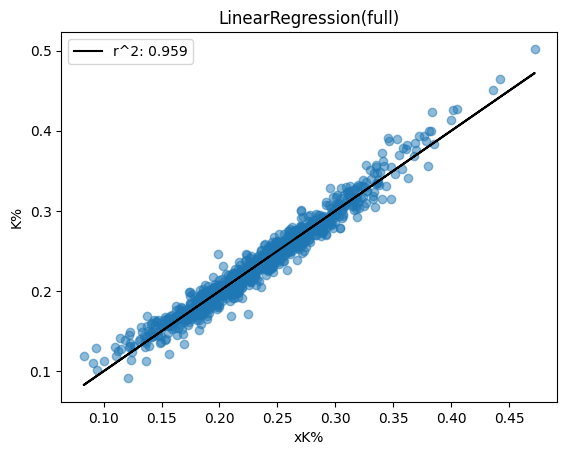

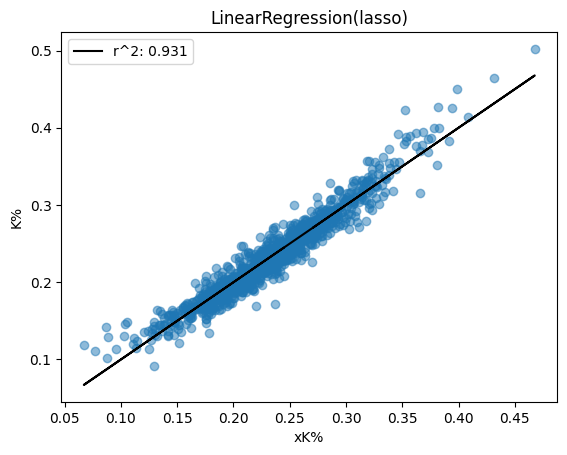

In [40]:
plot_pred_vs_target(
    X_df,
    y_df,
    lr_preds_full,
    "LinearRegression(full)",
)
plot_pred_vs_target(
    X_df,
    y_df,
    lr_preds_lasso,
    "LinearRegression(lasso)",
)

loading player ids from /Users/logan/Desktop/repos/mlb-pitcher-xK/data/player_ids.json...


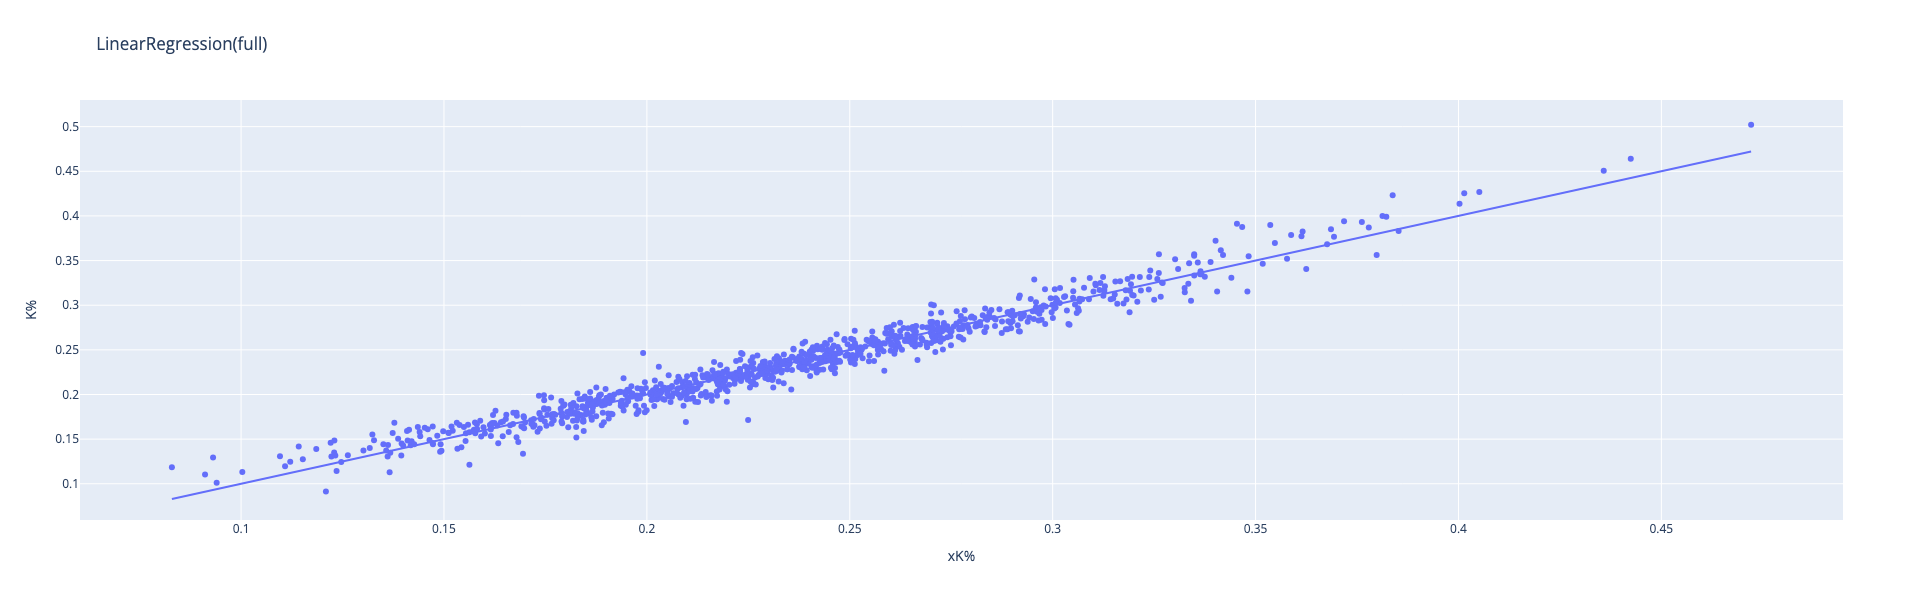

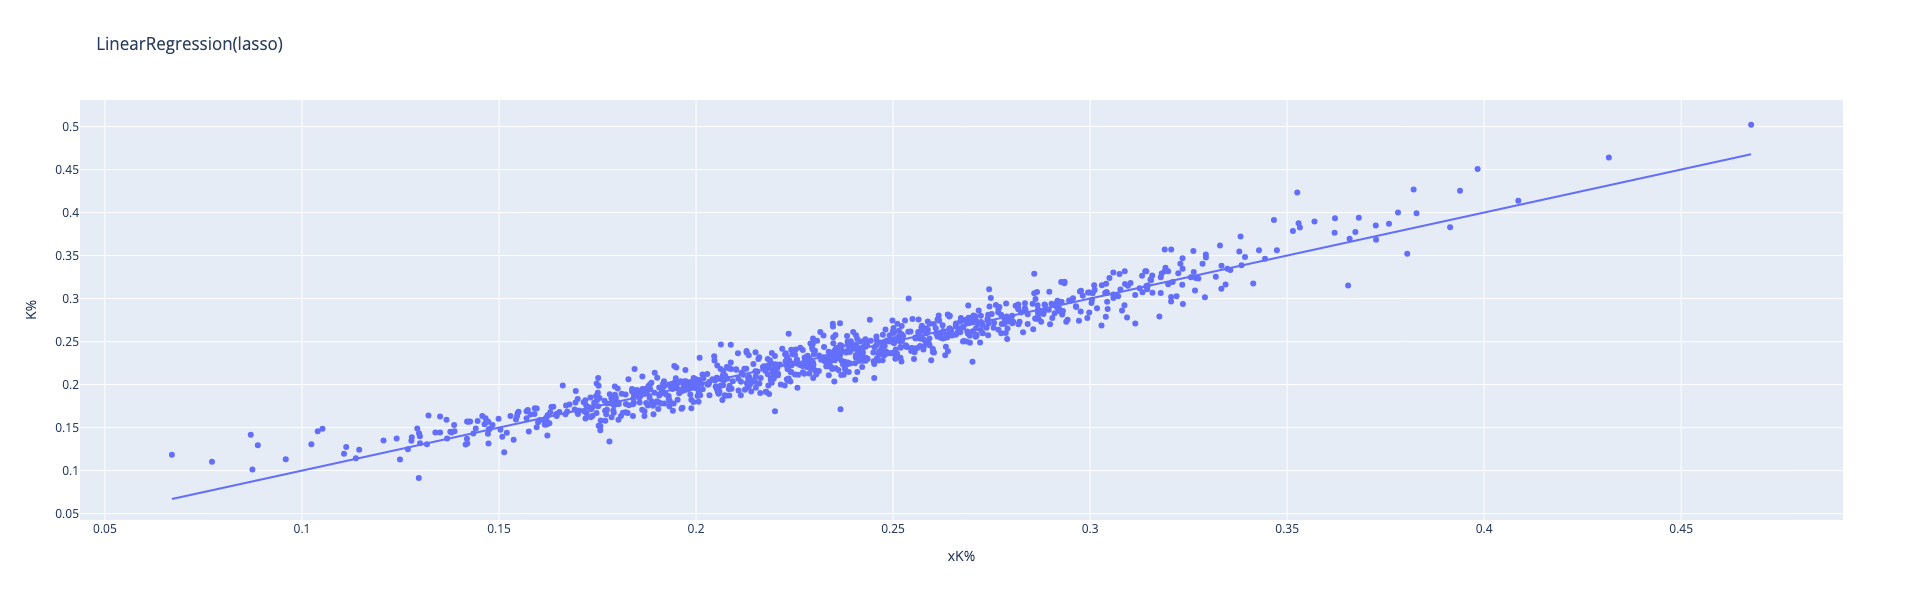

In [41]:
plot_pred_vs_target(
    X_df,
    y_df,
    lr_preds_full,
    "LinearRegression(full)",
    mode="interactive",
)
plot_pred_vs_target(
    X_df,
    y_df,
    lr_preds_lasso,
    "LinearRegression(lasso)",
    mode="interactive",
)

In [42]:
name, mlb_id, fangraphs_id = find_delta_extrema(
    X_df,
    y_df,
    lr_preds_lasso,
    extrema="max",
)
name, mlb_id, fangraphs_id

('Liam Hendriks', 521230, 3548)

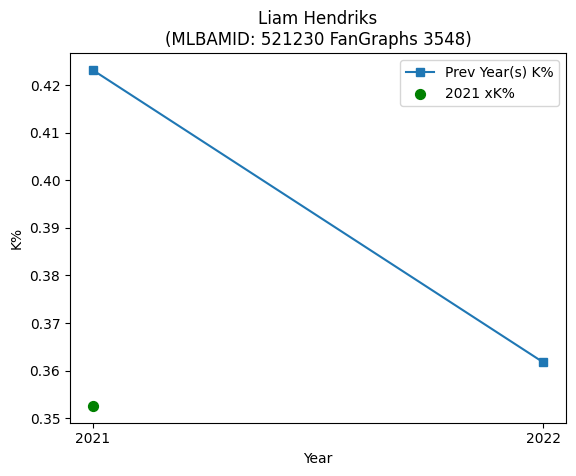

xK%: 0.3526
K% : [0.42322097, 0.36170213]


In [44]:
plot_player("Liam Hendriks", X_df, y_df, lr_preds_lasso, target_year=2021)

In [45]:
name, mlb_id, fangraphs_id = find_delta_extrema(
    X_df,
    y_df,
    lr_preds_lasso,
    extrema="min",
)
name, mlb_id, fangraphs_id

('Framber Valdez', 664285, 17295)

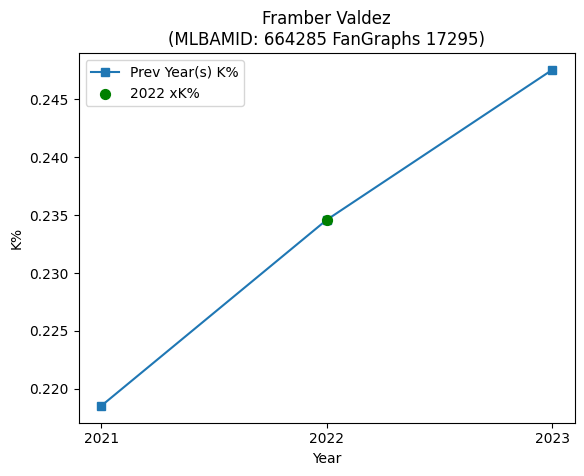

xK%: 0.2346
K% : [0.21853147, 0.23458283, 0.24752475]


In [49]:
plot_player("Framber Valdez", X_df, y_df, lr_preds_lasso, target_year=2022)

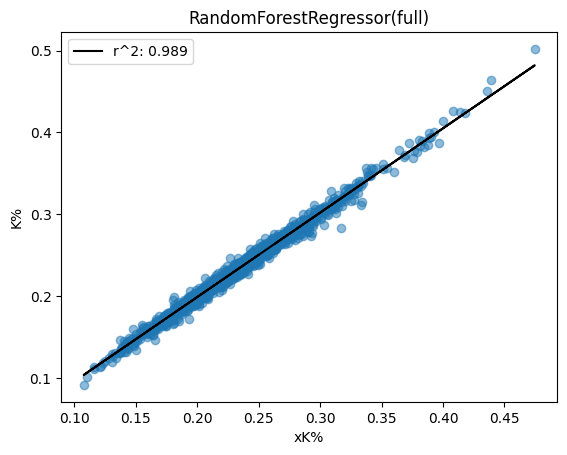

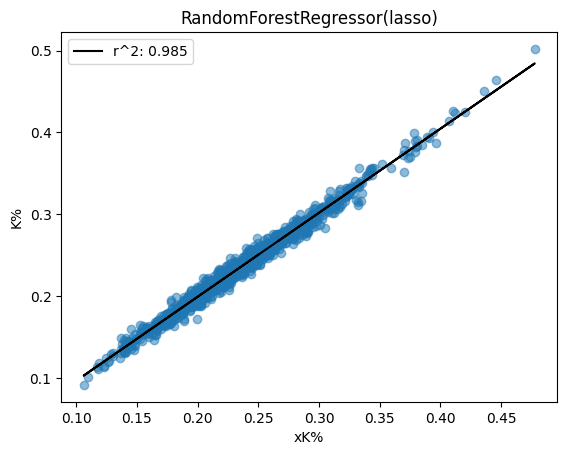

In [50]:
plot_pred_vs_target(
    X_df,
    y_df,
    rf_preds_full,
    "RandomForestRegressor(full)",
)
plot_pred_vs_target(
    X_df,
    y_df,
    rf_preds_lasso,
    "RandomForestRegressor(lasso)",
)

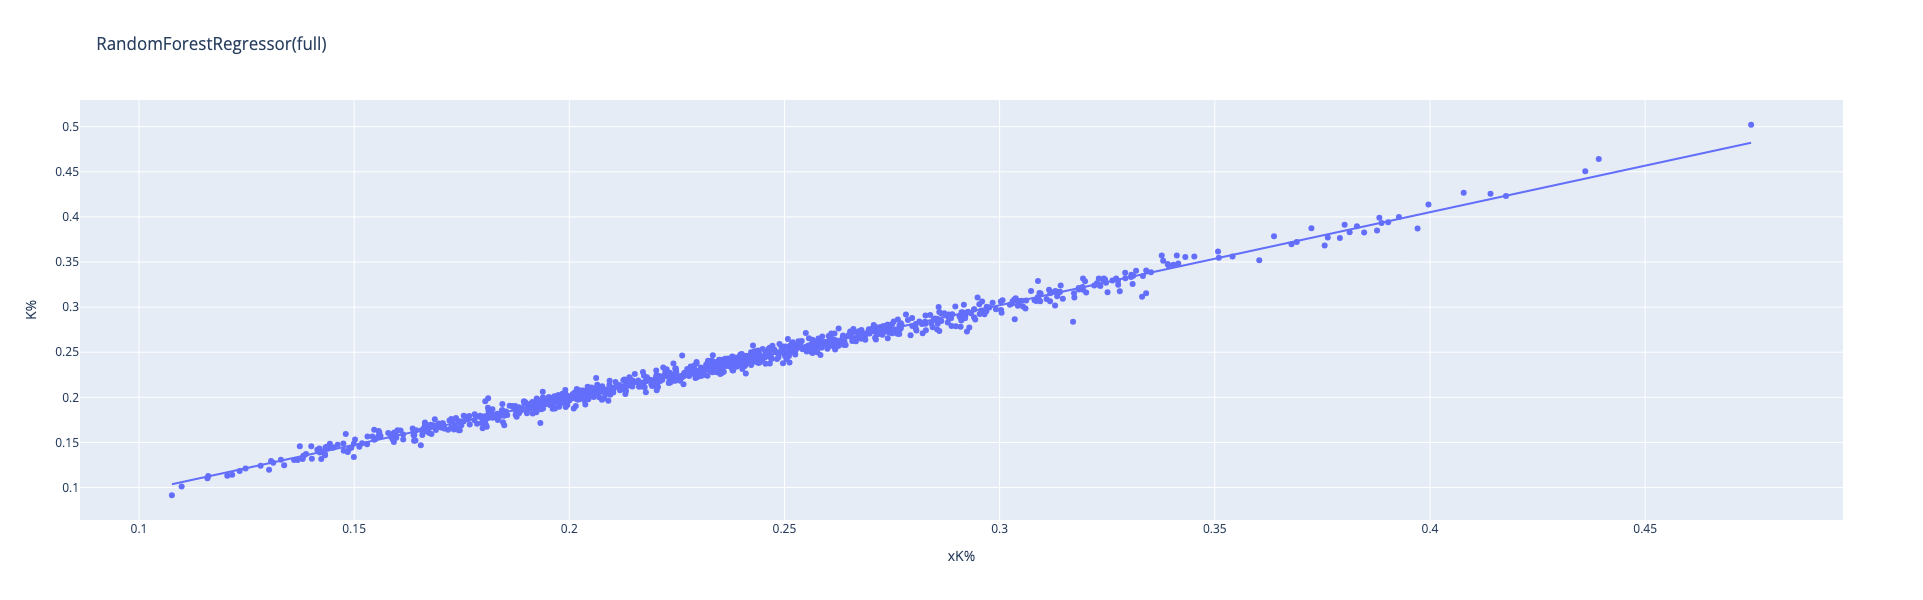

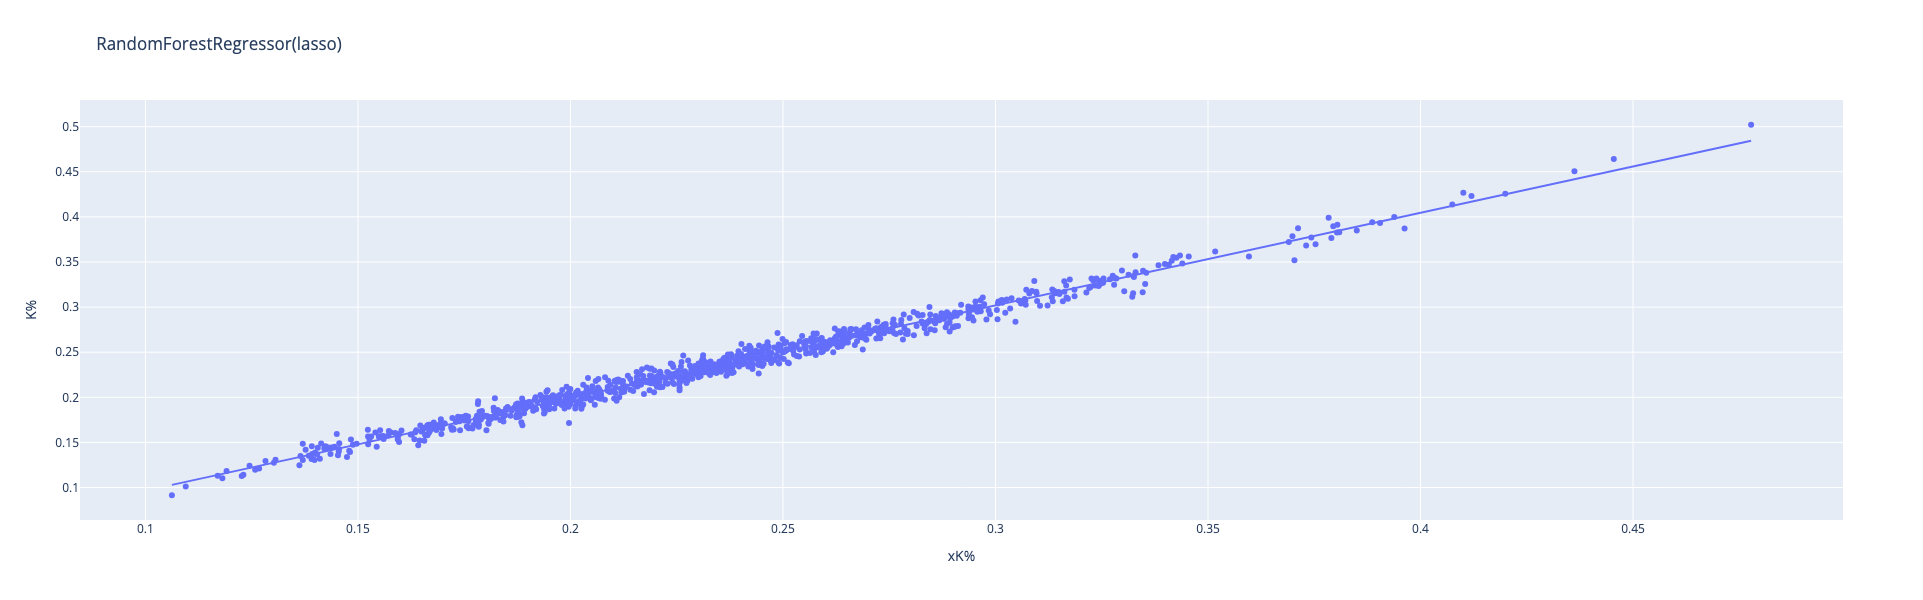

In [51]:
plot_pred_vs_target(
    X_df,
    y_df,
    rf_preds_full,
    "RandomForestRegressor(full)",
    mode="interactive",
)
plot_pred_vs_target(
    X_df,
    y_df,
    rf_preds_lasso,
    "RandomForestRegressor(lasso)",
    mode="interactive",
)

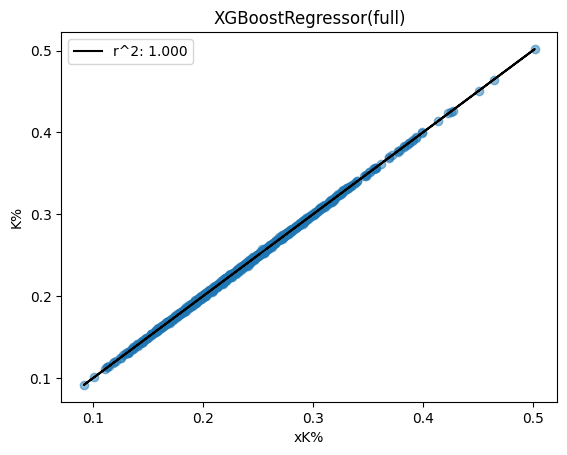

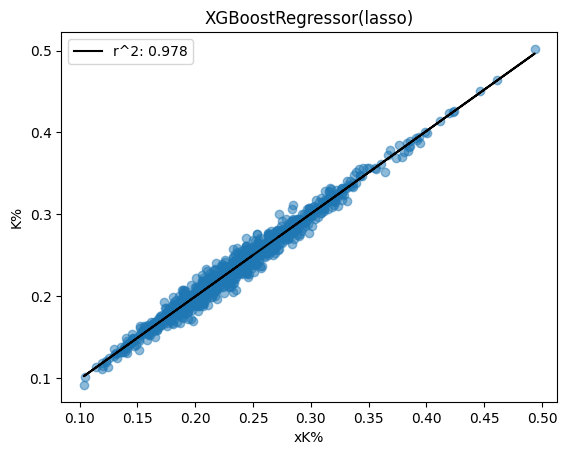

In [52]:
plot_pred_vs_target(
    X_df,
    y_df,
    xgb_preds_full,
    "XGBoostRegressor(full)",
)
plot_pred_vs_target(
    X_df,
    y_df,
    xgb_preds_lasso,
    "XGBoostRegressor(lasso)",
)

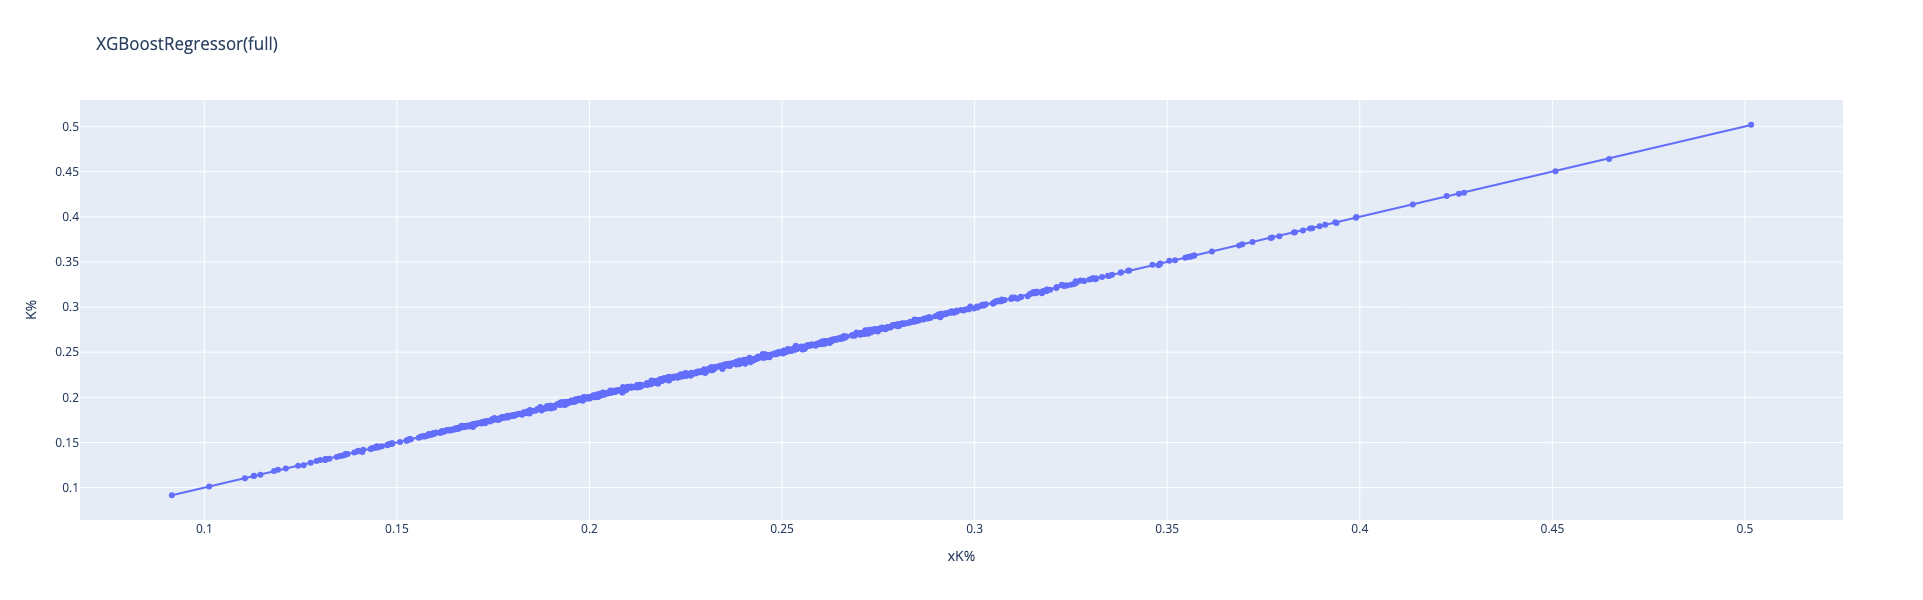

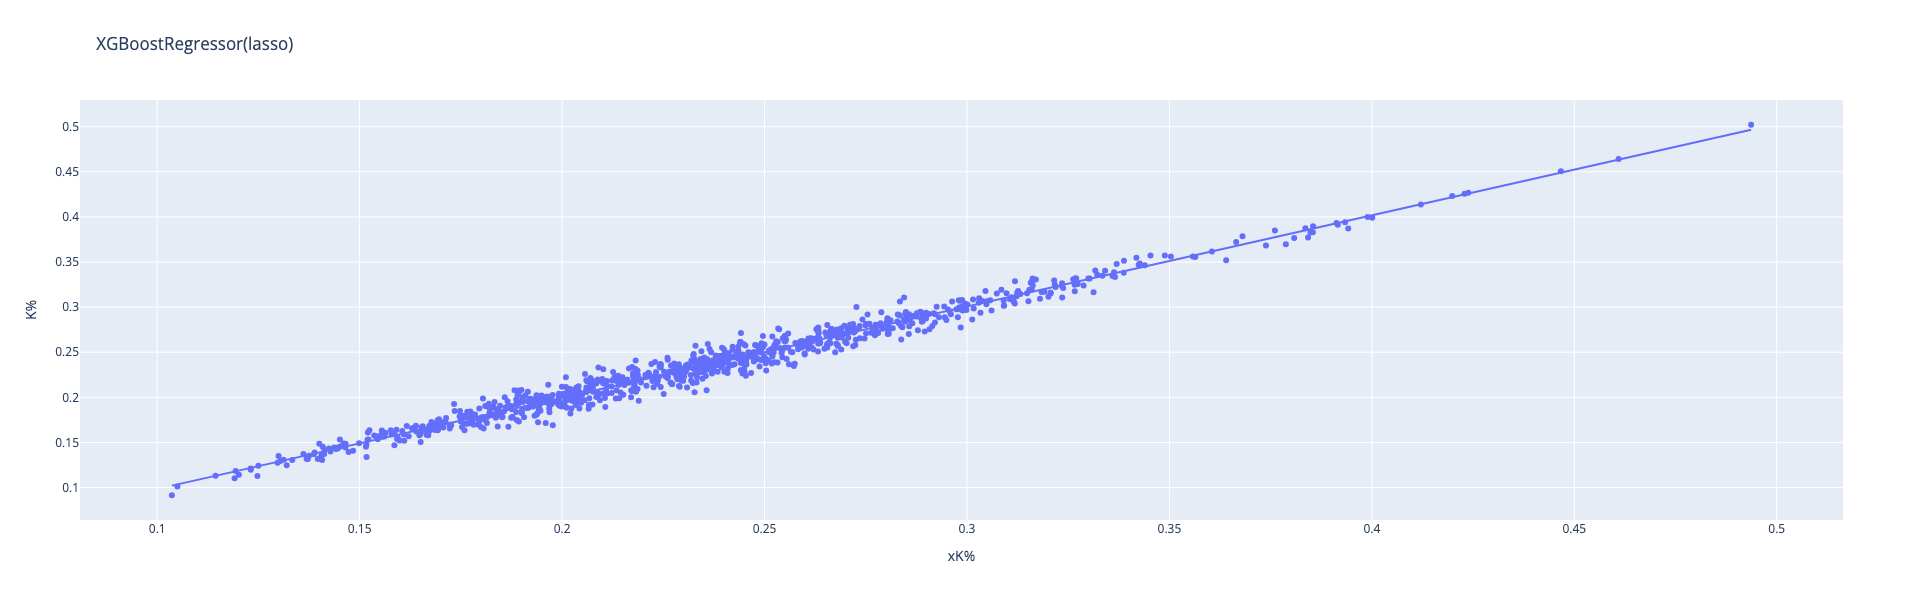

In [53]:
plot_pred_vs_target(
    X_df,
    y_df,
    xgb_preds_full,
    "XGBoostRegressor(full)",
    mode="interactive",
)
plot_pred_vs_target(
    X_df,
    y_df,
    xgb_preds_lasso,
    "XGBoostRegressor(lasso)",
    mode="interactive",
)

In [54]:
name, mlb_id, fangraphs_id = find_delta_extrema(
    X_df,
    y_df,
    xgb_preds_lasso,
    extrema="max",
)
name, mlb_id, fangraphs_id

('Daniel Duarte', 650960, 17480)

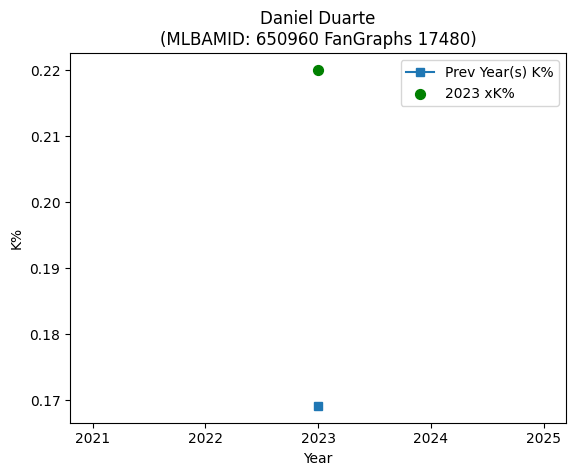

xK%: 0.2200
K% : [0.16911765]


In [56]:
plot_player("Daniel Duarte", X_df, y_df, lr_preds_lasso, target_year=2023)

## Save Models

In [58]:
# joblib.dump(lr_model_lasso, model_utils.MODEL_DIR.joinpath("linear.joblib"))
# joblib.dump(rf_model_full, model_utils.MODEL_DIR.joinpath("randomforest.joblib"))
# joblib.dump(xgb_model_full, model_utils.MODEL_DIR.joinpath("xgboost.joblib"))